In [1]:
from datetime import datetime
from distutils.util import strtobool
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler




# Converts the contents in a .tsf file into a dataframe and returns it along with other meta-data of the dataset: frequency, horizon, whether the dataset contains missing values and whether the series have equal lengths
#
# Parameters
# full_file_path_and_name - complete .tsf file path
# replace_missing_vals_with - a term to indicate the missing values in series in the returning dataframe
# value_column_name - Any name that is preferred to have as the name of the column containing series values in the returning dataframe
def convert_tsf_to_dataframe(
    full_file_path_and_name,
    replace_missing_vals_with="NaN",
    value_column_name="series_value",
):
    col_names = []
    col_types = []
    all_data = {}
    line_count = 0
    frequency = None
    forecast_horizon = None
    contain_missing_values = None
    contain_equal_length = None
    found_data_tag = False
    found_data_section = False
    started_reading_data_section = False

    with open(full_file_path_and_name, "r", encoding="cp1252") as file:
        for line in file:
            # Strip white space from start/end of line
            line = line.strip()

            if line:
                if line.startswith("@"):  # Read meta-data
                    if not line.startswith("@data"):
                        line_content = line.split(" ")
                        if line.startswith("@attribute"):
                            if (
                                len(line_content) != 3
                            ):  # Attributes have both name and type
                                raise Exception("Invalid meta-data specification.")

                            col_names.append(line_content[1])
                            col_types.append(line_content[2])
                        else:
                            if (
                                len(line_content) != 2
                            ):  # Other meta-data have only values
                                raise Exception("Invalid meta-data specification.")

                            if line.startswith("@frequency"):
                                frequency = line_content[1]
                            elif line.startswith("@horizon"):
                                forecast_horizon = int(line_content[1])
                            elif line.startswith("@missing"):
                                contain_missing_values = bool(
                                    strtobool(line_content[1])
                                )
                            elif line.startswith("@equallength"):
                                contain_equal_length = bool(strtobool(line_content[1]))

                    else:
                        if len(col_names) == 0:
                            raise Exception(
                                "Missing attribute section. Attribute section must come before data."
                            )

                        found_data_tag = True
                elif not line.startswith("#"):
                    if len(col_names) == 0:
                        raise Exception(
                            "Missing attribute section. Attribute section must come before data."
                        )
                    elif not found_data_tag:
                        raise Exception("Missing @data tag.")
                    else:
                        if not started_reading_data_section:
                            started_reading_data_section = True
                            found_data_section = True
                            all_series = []

                            for col in col_names:
                                all_data[col] = []

                        full_info = line.split(":")

                        if len(full_info) != (len(col_names) + 1):
                            raise Exception("Missing attributes/values in series.")

                        series = full_info[len(full_info) - 1]
                        series = series.split(",")

                        if len(series) == 0:
                            raise Exception(
                                "A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series. Missing values should be indicated with ? symbol"
                            )

                        numeric_series = []

                        for val in series:
                            if val == "?":
                                numeric_series.append(replace_missing_vals_with)
                            else:
                                numeric_series.append(float(val))

                        if numeric_series.count(replace_missing_vals_with) == len(
                            numeric_series
                        ):
                            raise Exception(
                                "All series values are missing. A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series."
                            )

                        all_series.append(pd.Series(numeric_series).array)

                        for i in range(len(col_names)):
                            att_val = None
                            if col_types[i] == "numeric":
                                att_val = int(full_info[i])
                            elif col_types[i] == "string":
                                att_val = str(full_info[i])
                            elif col_types[i] == "date":
                                att_val = datetime.strptime(
                                    full_info[i], "%Y-%m-%d %H-%M-%S"
                                )
                            else:
                                raise Exception(
                                    "Invalid attribute type."
                                )  # Currently, the code supports only numeric, string and date types. Extend this as required.

                            if att_val is None:
                                raise Exception("Invalid attribute value.")
                            else:
                                all_data[col_names[i]].append(att_val)

                line_count = line_count + 1

        if line_count == 0:
            raise Exception("Empty file.")
        if len(col_names) == 0:
            raise Exception("Missing attribute section.")
        if not found_data_section:
            raise Exception("Missing series information under data section.")

        all_data[value_column_name] = all_series
        loaded_data = pd.DataFrame(all_data)

        return (
            loaded_data,
            frequency,
            forecast_horizon,
            contain_missing_values,
            contain_equal_length,
        )


#loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe("TSForecasting/tsf_data/sample.tsf")

#print(loaded_data)
#print(frequency)
#print(forecast_horizon)
#print(contain_missing_values)
#print(contain_equal_length)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
training = pd.read_csv('/content/drive/MyDrive/Solar Farm Data/CSV data/building_solar_values.csv')
training = training.drop(['Building0','Building1','Building3','Building4','Building5','Building6'], axis=1)
training = training.dropna(axis=0)
training = training.set_index(pd.DatetimeIndex(training['Date'])).drop(['Date'], axis=1)
training

,Unnamed: 0,Solar0,Solar1,Solar2,Solar3,Solar4,Solar5
Date,,,,,,,
2020-04-26 00:00:00,133602,0.00,7.63,3.75,1.34,1.66,0.00
2020-04-26 00:15:00,133603,0.00,7.63,3.75,1.34,1.66,0.00
2020-04-26 00:30:00,133604,0.00,7.63,3.75,1.34,1.66,0.00
2020-04-26 00:45:00,133605,0.00,7.63,3.75,1.34,1.66,0.00
2020-04-26 01:00:00,133606,0.00,7.63,3.75,1.34,1.66,0.00
...,...,...,...,...,...,...,...
2020-11-01 08:45:00,151781,18.53,4.96,4.73,4.31,2.84,13.47
2020-11-01 09:00:00,151782,22.23,5.88,5.64,5.08,3.40,15.93
2020-11-01 09:15:00,151783,23.39,6.31,5.99,5.45,3.62,17.11


In [34]:
testing = pd.read_csv('/content/drive/MyDrive/Solar Farm Data/CSV data/finaltest.csv')
testing = testing.drop(['Building0','Building1','Building3','Building4','Building5','Building6'], axis=1)
testing = testing.dropna(axis=0)
testing = testing.set_index(pd.DatetimeIndex(testing['Date'])).drop(['Date'], axis=1)
testing

,Unnamed: 0,Solar0,Solar1,Solar2,Solar3,Solar4,Solar5
Date,,,,,,,
2020-04-26 00:00:00,133602,0.00,7.63,3.75,1.34,1.66,0.00
2020-04-26 00:15:00,133603,0.00,7.63,3.75,1.34,1.66,0.00
2020-04-26 00:30:00,133604,0.00,7.63,3.75,1.34,1.66,0.00
2020-04-26 00:45:00,133605,0.00,7.63,3.75,1.34,1.66,0.00
2020-04-26 01:00:00,133606,0.00,7.63,3.75,1.34,1.66,0.00
...,...,...,...,...,...,...,...
2020-12-01 08:45:00,154661,13.21,2.32,2.21,3.11,1.31,9.86
2020-12-01 09:00:00,154662,8.24,2.21,2.10,1.97,1.25,6.22
2020-12-01 09:15:00,154663,9.42,2.00,1.90,2.24,1.13,7.14


# 1. EDA

##**Solar** 0

In [58]:
solar0_train = testing[['Solar0']]
solar0_train = solar0_train.rename({'Solar0': 'Power output'}, axis=1)
solar0_train = solar0_train.dropna(axis =0)
solar0_train

,Power output
Date,
2020-04-26 00:00:00,0.00
2020-04-26 00:15:00,0.00
2020-04-26 00:30:00,0.00
2020-04-26 00:45:00,0.00
2020-04-26 01:00:00,0.00
...,...
2020-12-01 08:45:00,13.21
2020-12-01 09:00:00,8.24
2020-12-01 09:15:00,9.42


In [57]:
solar0_test = testing[['Solar1']]
solar0_test = solar0_test.rename({'Solar1': 'Power output'}, axis=1)
solar0_test = solar0_test.dropna(axis =0)
solar0_test = solar0_test[pd.Timestamp('2020-11-01 00:00:00'):pd.Timestamp("2020-12-01 00:00:00")]
solar0_test

,Power output
Date,
2020-11-01 00:00:00,0.0
2020-11-01 00:15:00,0.0
2020-11-01 00:30:00,0.0
2020-11-01 00:45:00,0.0
2020-11-01 01:00:00,0.0
...,...
2020-11-30 23:00:00,0.0
2020-11-30 23:15:00,0.0
2020-11-30 23:30:00,0.0


## Solar 1

In [36]:
solar1_train = training[['Solar1']]
solar1_train = solar1_train.rename({'Solar1': 'Power output'}, axis=1)
solar1_train = solar1_train.dropna(axis =0)
#start = '2019-09-01 00:00:00'
solar1_train = solar1_train[pd.Timestamp('2019-09-01 00:00:00'):pd.Timestamp("2020-10-31 00:00:00")]
solar1_train

,Power output
Date,
2020-04-26 00:00:00,7.63
2020-04-26 00:15:00,7.63
2020-04-26 00:30:00,7.63
2020-04-26 00:45:00,7.63
2020-04-26 01:00:00,7.63
...,...
2020-10-30 23:00:00,0.00
2020-10-30 23:15:00,0.00
2020-10-30 23:30:00,0.00


In [55]:
solar1_test = testing[['Solar1']]
solar1_test = solar1_test.rename({'Solar1': 'Power output'}, axis=1)
solar1_test = solar1_test.dropna(axis =0)
solar1_test = solar1_test[pd.Timestamp('2020-11-01 00:00:00'):pd.Timestamp("2020-12-01 00:00:00")]
solar1_test

,Power output
Date,
2020-11-01 00:00:00,0.0
2020-11-01 00:15:00,0.0
2020-11-01 00:30:00,0.0
2020-11-01 00:45:00,0.0
2020-11-01 01:00:00,0.0
...,...
2020-11-30 23:00:00,0.0
2020-11-30 23:15:00,0.0
2020-11-30 23:30:00,0.0


## Solar 2

In [59]:
solar2_train = testing[['Solar2']]
solar2_train = solar2_train.rename({'Solar2': 'Power output'}, axis=1)
#solar2 = solar2.dropna(axis =0)
#solar2 = solar2[pd.Timestamp('2019-09-01 00:00:00'):pd.Timestamp("2020-10-31 00:00:00")]
solar2_train

,Power output
Date,
2020-04-26 00:00:00,3.75
2020-04-26 00:15:00,3.75
2020-04-26 00:30:00,3.75
2020-04-26 00:45:00,3.75
2020-04-26 01:00:00,3.75
...,...
2020-12-01 08:45:00,2.21
2020-12-01 09:00:00,2.10
2020-12-01 09:15:00,1.90


In [56]:
solar2_test = testing[['Solar2']]
solar2_test = solar2_test.rename({'Solar2': 'Power output'}, axis=1)
solar2_test = solar2_test.dropna(axis =0)
solar2_test = solar2_test[pd.Timestamp('2020-11-01 00:00:00'):pd.Timestamp("2020-12-01 00:00:00")]
solar2_test

,Power output
Date,
2020-11-01 00:00:00,0.0
2020-11-01 00:15:00,0.0
2020-11-01 00:30:00,0.0
2020-11-01 00:45:00,0.0
2020-11-01 01:00:00,0.0
...,...
2020-11-30 23:00:00,0.0
2020-11-30 23:15:00,0.0
2020-11-30 23:30:00,0.0


## Solar 3

In [7]:
solar3 = testing[['Solar3']]
solar3 = solar3.rename({'Solar3': 'Power output'}, axis=1)
solar3 = solar3.dropna(axis =0)
solar3

,Power output
Date,
2020-04-26 00:00:00,1.34
2020-04-26 00:15:00,1.34
2020-04-26 00:30:00,1.34
2020-04-26 00:45:00,1.34
2020-04-26 01:00:00,1.34
...,...
2020-11-01 08:45:00,4.31
2020-11-01 09:00:00,5.08
2020-11-01 09:15:00,5.45


## Solar 4

In [8]:
solar4 = testing[['Solar4']]
solar4 = solar4.rename({'Solar4': 'Power output'}, axis=1)
solar4 = solar4.dropna(axis =0)
solar4

,Power output
Date,
2020-04-26 00:00:00,1.66
2020-04-26 00:15:00,1.66
2020-04-26 00:30:00,1.66
2020-04-26 00:45:00,1.66
2020-04-26 01:00:00,1.66
...,...
2020-11-01 08:45:00,2.84
2020-11-01 09:00:00,3.40
2020-11-01 09:15:00,3.62


## Solar 5

In [9]:
solar5 = testing[['Solar5']]
solar5 = solar5.rename({'Solar5': 'Power output'}, axis=1)
solar5 = solar5.dropna(axis =0)
solar5

,Power output
Date,
2020-04-26 00:00:00,0.00
2020-04-26 00:15:00,0.00
2020-04-26 00:30:00,0.00
2020-04-26 00:45:00,0.00
2020-04-26 01:00:00,0.00
...,...
2020-11-01 08:45:00,13.47
2020-11-01 09:00:00,15.93
2020-11-01 09:15:00,17.11



## Combining Weather data with Solar dataset



### Loading weather data

In [10]:
weather = pd.read_csv("/content/drive/MyDrive/Solar Farm Data/ERA5_Weather_Data_Monash.zip")
weather

,datetime (UTC),"coordinates (lat,lon)",model (name),model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
0,2010-01-01 00:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.26,16.39,2.60,101046.38,0.89,287.01,408.35,1.00
1,2010-01-01 01:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.67,16.29,2.91,101037.96,0.86,360.79,411.02,1.00
2,2010-01-01 02:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.16,15.89,3.26,101017.26,0.87,291.54,410.67,1.00
3,2010-01-01 03:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.46,15.33,3.17,101022.56,0.82,357.11,410.95,1.00
4,2010-01-01 04:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.53,15.11,2.95,100940.03,0.80,459.91,410.00,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100052,2021-05-31 20:00:00,"(-37.91, 145.13)",era5,69.59,10.0,8.31,3.28,4.91,102033.73,0.71,0.00,278.11,0.93
100053,2021-05-31 21:00:00,"(-37.91, 145.13)",era5,69.59,10.0,8.15,3.16,4.63,102033.49,0.71,0.00,277.98,1.00
100054,2021-05-31 22:00:00,"(-37.91, 145.13)",era5,69.59,10.0,8.72,3.31,5.29,102069.84,0.69,8.99,281.65,1.00
100055,2021-05-31 23:00:00,"(-37.91, 145.13)",era5,69.59,10.0,9.83,3.88,5.60,102077.12,0.66,80.46,296.20,1.00


In [11]:
weather = weather.set_index(pd.DatetimeIndex(weather['datetime (UTC)'])).drop(weather.columns[0], axis=1)
weather

,"coordinates (lat,lon)",model (name),model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
datetime (UTC),,,,,,,,,,,,
2010-01-01 00:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.26,16.39,2.60,101046.38,0.89,287.01,408.35,1.00
2010-01-01 01:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.67,16.29,2.91,101037.96,0.86,360.79,411.02,1.00
2010-01-01 02:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.16,15.89,3.26,101017.26,0.87,291.54,410.67,1.00
2010-01-01 03:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.46,15.33,3.17,101022.56,0.82,357.11,410.95,1.00
2010-01-01 04:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.53,15.11,2.95,100940.03,0.80,459.91,410.00,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31 20:00:00,"(-37.91, 145.13)",era5,69.59,10.0,8.31,3.28,4.91,102033.73,0.71,0.00,278.11,0.93
2021-05-31 21:00:00,"(-37.91, 145.13)",era5,69.59,10.0,8.15,3.16,4.63,102033.49,0.71,0.00,277.98,1.00
2021-05-31 22:00:00,"(-37.91, 145.13)",era5,69.59,10.0,8.72,3.31,5.29,102069.84,0.69,8.99,281.65,1.00


In [12]:
weather = weather.resample("15T").mean().round(1) #Resampling into 15-minute intervals
weather

<ipython-input-12-6fc315b3b116>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  weather = weather.resample("15T").mean().round(1) #Resampling into 15-minute intervals


,model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
datetime (UTC),,,,,,,,,,
2010-01-01 00:00:00,69.6,10.0,18.3,16.4,2.6,101046.4,0.9,287.0,408.4,1.0
2010-01-01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 01:00:00,69.6,10.0,18.7,16.3,2.9,101038.0,0.9,360.8,411.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2021-05-31 23:00:00,69.6,10.0,9.8,3.9,5.6,102077.1,0.7,80.5,296.2,1.0
2021-05-31 23:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-31 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
weather.isna().sum()

model elevation (surface)            300168
utc_offset (hrs)                     300168
temperature (degC)                   300168
dewpoint_temperature (degC)          300168
wind_speed (m/s)                     300168
mean_sea_level_pressure (Pa)         300168
relative_humidity ((0-1))            300168
surface_solar_radiation (W/m^2)      300168
surface_thermal_radiation (W/m^2)    300168
total_cloud_cover (0-1)              300168
dtype: int64

In [14]:
weather = weather.interpolate(method='linear') #Input NaN
weather

,model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
datetime (UTC),,,,,,,,,,
2010-01-01 00:00:00,69.6,10.0,18.300,16.400,2.600,101046.400,0.900,287.000,408.40,1.0
2010-01-01 00:15:00,69.6,10.0,18.400,16.375,2.675,101044.300,0.900,305.450,409.05,1.0
2010-01-01 00:30:00,69.6,10.0,18.500,16.350,2.750,101042.200,0.900,323.900,409.70,1.0
2010-01-01 00:45:00,69.6,10.0,18.600,16.325,2.825,101040.100,0.900,342.350,410.35,1.0
2010-01-01 01:00:00,69.6,10.0,18.700,16.300,2.900,101038.000,0.900,360.800,411.00,1.0
...,...,...,...,...,...,...,...,...,...,...
2021-05-31 23:00:00,69.6,10.0,9.800,3.900,5.600,102077.100,0.700,80.500,296.20,1.0
2021-05-31 23:15:00,69.6,10.0,10.025,3.975,5.550,102085.225,0.675,97.825,298.50,1.0
2021-05-31 23:30:00,69.6,10.0,10.250,4.050,5.500,102093.350,0.650,115.150,300.80,1.0


In [15]:
weather.isna().sum()

model elevation (surface)            0
utc_offset (hrs)                     0
temperature (degC)                   0
dewpoint_temperature (degC)          0
wind_speed (m/s)                     0
mean_sea_level_pressure (Pa)         0
relative_humidity ((0-1))            0
surface_solar_radiation (W/m^2)      0
surface_thermal_radiation (W/m^2)    0
total_cloud_cover (0-1)              0
dtype: int64

In [16]:
weather.index.names = ['timestamp']
weather

,model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,,,
2010-01-01 00:00:00,69.6,10.0,18.300,16.400,2.600,101046.400,0.900,287.000,408.40,1.0
2010-01-01 00:15:00,69.6,10.0,18.400,16.375,2.675,101044.300,0.900,305.450,409.05,1.0
2010-01-01 00:30:00,69.6,10.0,18.500,16.350,2.750,101042.200,0.900,323.900,409.70,1.0
2010-01-01 00:45:00,69.6,10.0,18.600,16.325,2.825,101040.100,0.900,342.350,410.35,1.0
2010-01-01 01:00:00,69.6,10.0,18.700,16.300,2.900,101038.000,0.900,360.800,411.00,1.0
...,...,...,...,...,...,...,...,...,...,...
2021-05-31 23:00:00,69.6,10.0,9.800,3.900,5.600,102077.100,0.700,80.500,296.20,1.0
2021-05-31 23:15:00,69.6,10.0,10.025,3.975,5.550,102085.225,0.675,97.825,298.50,1.0
2021-05-31 23:30:00,69.6,10.0,10.250,4.050,5.500,102093.350,0.650,115.150,300.80,1.0


In [17]:
solar0 = pd.merge(solar0, weather, left_index=True, right_index=True)
solar0 = solar0.drop(['model elevation (surface)','utc_offset (hrs)'], axis = 1)
solar0

,Power output,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
2020-04-26 00:00:00,0.00,15.500,13.500,6.200,101355.60,0.900,142.500,366.800,1.0
2020-04-26 00:15:00,0.00,15.425,13.325,6.300,101380.10,0.900,162.475,363.550,1.0
2020-04-26 00:30:00,0.00,15.350,13.150,6.400,101404.60,0.900,182.450,360.300,1.0
2020-04-26 00:45:00,0.00,15.275,12.975,6.500,101429.10,0.900,202.425,357.050,1.0
2020-04-26 01:00:00,0.00,15.200,12.800,6.600,101453.60,0.900,222.400,353.800,1.0
...,...,...,...,...,...,...,...,...,...
2020-11-01 08:45:00,18.53,14.350,10.550,4.200,102413.70,0.775,90.850,292.000,0.0
2020-11-01 09:00:00,22.23,14.000,10.500,4.100,102431.70,0.800,45.000,291.200,0.0
2020-11-01 09:15:00,23.39,13.675,10.425,3.875,102446.55,0.800,33.750,290.375,0.0
2020-11-01 09:30:00,24.56,13.350,10.350,3.650,102461.40,0.800,22.500,289.550,0.0


In [40]:
solar1_train = pd.merge(solar1_train, weather, left_index=True, right_index=True)
solar1_train = solar1_train.drop(['model elevation (surface)','utc_offset (hrs)'], axis = 1)
solar1_train

,Power output,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
2020-04-26 00:00:00,7.63,15.500,13.500,6.2,101355.6,0.9,142.500,366.80,1.0
2020-04-26 00:15:00,7.63,15.425,13.325,6.3,101380.1,0.9,162.475,363.55,1.0
2020-04-26 00:30:00,7.63,15.350,13.150,6.4,101404.6,0.9,182.450,360.30,1.0
2020-04-26 00:45:00,7.63,15.275,12.975,6.5,101429.1,0.9,202.425,357.05,1.0
2020-04-26 01:00:00,7.63,15.200,12.800,6.6,101453.6,0.9,222.400,353.80,1.0
...,...,...,...,...,...,...,...,...,...
2020-10-30 23:00:00,0.00,15.600,12.200,4.5,101466.3,0.8,309.200,357.50,1.0
2020-10-30 23:15:00,0.00,15.725,12.200,4.6,101469.2,0.8,325.725,358.50,1.0
2020-10-30 23:30:00,0.00,15.850,12.200,4.7,101472.1,0.8,342.250,359.50,1.0
2020-10-30 23:45:00,0.00,15.975,12.200,4.8,101475.0,0.8,358.775,360.50,1.0


In [41]:
solar1_test = pd.merge(solar1_test, weather, left_index=True, right_index=True)
solar1_test = solar1_test.drop(['model elevation (surface)','utc_offset (hrs)'], axis = 1)
solar1_test

,Power output,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
2020-11-01 00:00:00,0.0,14.400,9.3,3.000,102398.800,0.7,497.60,355.400,0.900
2020-11-01 00:15:00,0.0,14.750,9.4,3.075,102398.025,0.7,544.05,353.825,0.925
2020-11-01 00:30:00,0.0,15.100,9.5,3.150,102397.250,0.7,590.50,352.250,0.950
2020-11-01 00:45:00,0.0,15.450,9.6,3.225,102396.475,0.7,636.95,350.675,0.975
2020-11-01 01:00:00,0.0,15.800,9.7,3.300,102395.700,0.7,683.40,349.100,1.000
...,...,...,...,...,...,...,...,...,...
2020-11-30 23:00:00,0.0,24.300,14.3,6.400,100331.900,0.5,236.50,374.800,1.000
2020-11-30 23:15:00,0.0,24.475,14.3,6.525,100351.525,0.5,224.30,377.975,1.000
2020-11-30 23:30:00,0.0,24.650,14.3,6.650,100371.150,0.5,212.10,381.150,1.000
2020-11-30 23:45:00,0.0,24.825,14.3,6.775,100390.775,0.5,199.90,384.325,1.000


In [19]:
solar2 = pd.merge(solar2, weather, left_index=True, right_index=True)
solar2 = solar2.drop(['model elevation (surface)','utc_offset (hrs)'], axis = 1)
solar2

,Power output,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
2020-04-26 00:00:00,3.75,15.500,13.500,6.200,101355.60,0.900,142.500,366.800,1.0
2020-04-26 00:15:00,3.75,15.425,13.325,6.300,101380.10,0.900,162.475,363.550,1.0
2020-04-26 00:30:00,3.75,15.350,13.150,6.400,101404.60,0.900,182.450,360.300,1.0
2020-04-26 00:45:00,3.75,15.275,12.975,6.500,101429.10,0.900,202.425,357.050,1.0
2020-04-26 01:00:00,3.75,15.200,12.800,6.600,101453.60,0.900,222.400,353.800,1.0
...,...,...,...,...,...,...,...,...,...
2020-11-01 08:45:00,4.73,14.350,10.550,4.200,102413.70,0.775,90.850,292.000,0.0
2020-11-01 09:00:00,5.64,14.000,10.500,4.100,102431.70,0.800,45.000,291.200,0.0
2020-11-01 09:15:00,5.99,13.675,10.425,3.875,102446.55,0.800,33.750,290.375,0.0
2020-11-01 09:30:00,6.35,13.350,10.350,3.650,102461.40,0.800,22.500,289.550,0.0


In [20]:
solar3 = pd.merge(solar3, weather, left_index=True, right_index=True)
solar3 = solar3.drop(['model elevation (surface)','utc_offset (hrs)'], axis = 1)
solar3

,Power output,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
2020-04-26 00:00:00,1.34,15.500,13.500,6.200,101355.60,0.900,142.500,366.800,1.0
2020-04-26 00:15:00,1.34,15.425,13.325,6.300,101380.10,0.900,162.475,363.550,1.0
2020-04-26 00:30:00,1.34,15.350,13.150,6.400,101404.60,0.900,182.450,360.300,1.0
2020-04-26 00:45:00,1.34,15.275,12.975,6.500,101429.10,0.900,202.425,357.050,1.0
2020-04-26 01:00:00,1.34,15.200,12.800,6.600,101453.60,0.900,222.400,353.800,1.0
...,...,...,...,...,...,...,...,...,...
2020-11-01 08:45:00,4.31,14.350,10.550,4.200,102413.70,0.775,90.850,292.000,0.0
2020-11-01 09:00:00,5.08,14.000,10.500,4.100,102431.70,0.800,45.000,291.200,0.0
2020-11-01 09:15:00,5.45,13.675,10.425,3.875,102446.55,0.800,33.750,290.375,0.0
2020-11-01 09:30:00,5.83,13.350,10.350,3.650,102461.40,0.800,22.500,289.550,0.0


In [21]:
solar4 = pd.merge(solar4, weather, left_index=True, right_index=True)
solar4 = solar4.drop(['model elevation (surface)','utc_offset (hrs)'], axis = 1)
solar4

,Power output,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
2020-04-26 00:00:00,1.66,15.500,13.500,6.200,101355.60,0.900,142.500,366.800,1.0
2020-04-26 00:15:00,1.66,15.425,13.325,6.300,101380.10,0.900,162.475,363.550,1.0
2020-04-26 00:30:00,1.66,15.350,13.150,6.400,101404.60,0.900,182.450,360.300,1.0
2020-04-26 00:45:00,1.66,15.275,12.975,6.500,101429.10,0.900,202.425,357.050,1.0
2020-04-26 01:00:00,1.66,15.200,12.800,6.600,101453.60,0.900,222.400,353.800,1.0
...,...,...,...,...,...,...,...,...,...
2020-11-01 08:45:00,2.84,14.350,10.550,4.200,102413.70,0.775,90.850,292.000,0.0
2020-11-01 09:00:00,3.40,14.000,10.500,4.100,102431.70,0.800,45.000,291.200,0.0
2020-11-01 09:15:00,3.62,13.675,10.425,3.875,102446.55,0.800,33.750,290.375,0.0
2020-11-01 09:30:00,3.85,13.350,10.350,3.650,102461.40,0.800,22.500,289.550,0.0


In [22]:
solar5 = pd.merge(solar5, weather, left_index=True, right_index=True)
solar5 = solar5.drop(['model elevation (surface)','utc_offset (hrs)'], axis = 1)
solar5

,Power output,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
2020-04-26 00:00:00,0.00,15.500,13.500,6.200,101355.60,0.900,142.500,366.800,1.0
2020-04-26 00:15:00,0.00,15.425,13.325,6.300,101380.10,0.900,162.475,363.550,1.0
2020-04-26 00:30:00,0.00,15.350,13.150,6.400,101404.60,0.900,182.450,360.300,1.0
2020-04-26 00:45:00,0.00,15.275,12.975,6.500,101429.10,0.900,202.425,357.050,1.0
2020-04-26 01:00:00,0.00,15.200,12.800,6.600,101453.60,0.900,222.400,353.800,1.0
...,...,...,...,...,...,...,...,...,...
2020-11-01 08:45:00,13.47,14.350,10.550,4.200,102413.70,0.775,90.850,292.000,0.0
2020-11-01 09:00:00,15.93,14.000,10.500,4.100,102431.70,0.800,45.000,291.200,0.0
2020-11-01 09:15:00,17.11,13.675,10.425,3.875,102446.55,0.800,33.750,290.375,0.0
2020-11-01 09:30:00,18.29,13.350,10.350,3.650,102461.40,0.800,22.500,289.550,0.0


### Correlation

<ipython-input-23-20c5e97135e0>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corrs, dtype=np.bool)) # create a mask to only show entries below the main diagonal


(9.5, -0.5)

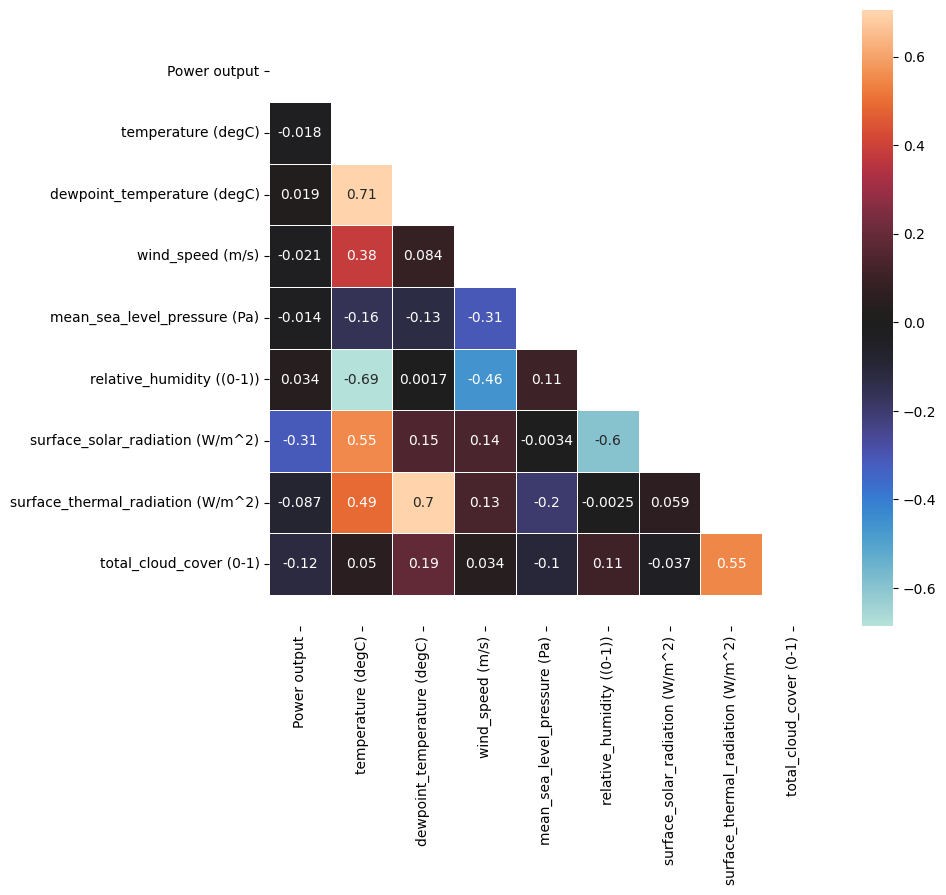

In [23]:
corrs = solar0.corr()
mask = np.triu(np.ones_like(corrs, dtype=np.bool)) # create a mask to only show entries below the main diagonal
f, ax = plt.subplots(figsize=(10, 8))
# plot the heatmap with a colour bar
sns.heatmap(corrs, mask=mask, center=0, annot=True, square=True, linewidths=.5)
# adjust the top and bottom, so that we can see the whole figure
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

<ipython-input-24-22f15deb96d5>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corrs, dtype=np.bool)) # create a mask to only show entries below the main diagonal


(9.5, -0.5)

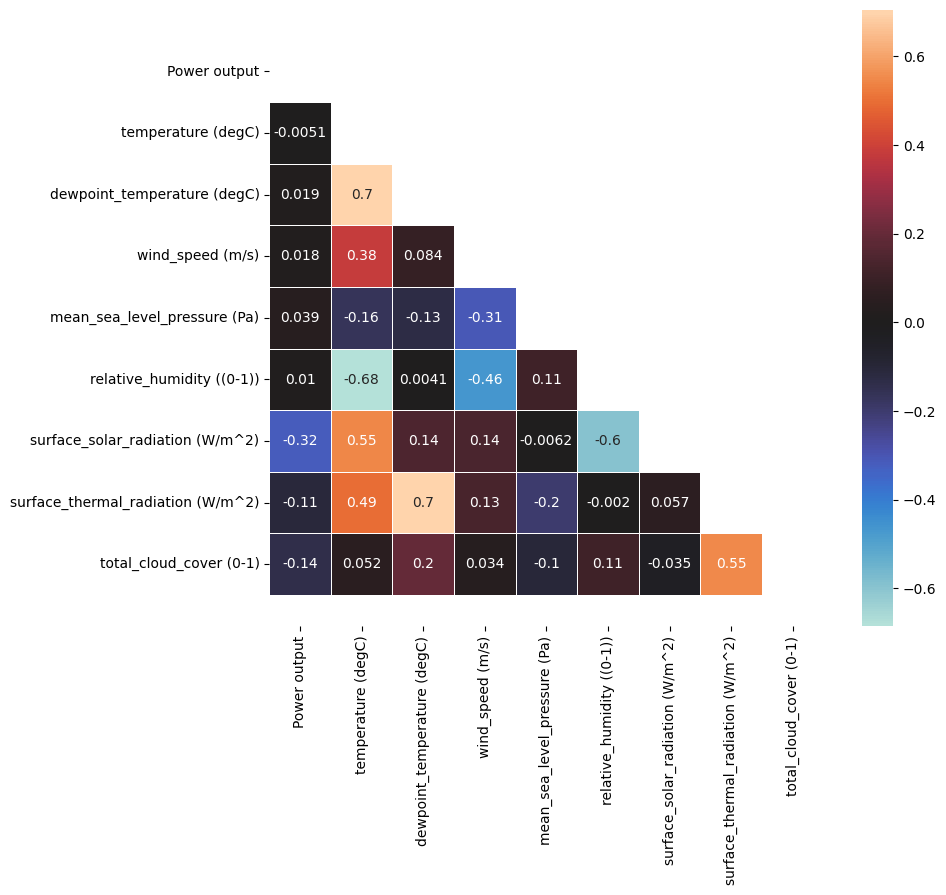

In [24]:
corrs = solar1.corr()
mask = np.triu(np.ones_like(corrs, dtype=np.bool)) # create a mask to only show entries below the main diagonal
f, ax = plt.subplots(figsize=(10, 8))
# plot the heatmap with a colour bar
sns.heatmap(corrs, mask=mask, center=0, annot=True, square=True, linewidths=.5)
# adjust the top and bottom, so that we can see the whole figure
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

<ipython-input-25-95de14f37284>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corrs, dtype=np.bool)) # create a mask to only show entries below the main diagonal


(9.5, -0.5)

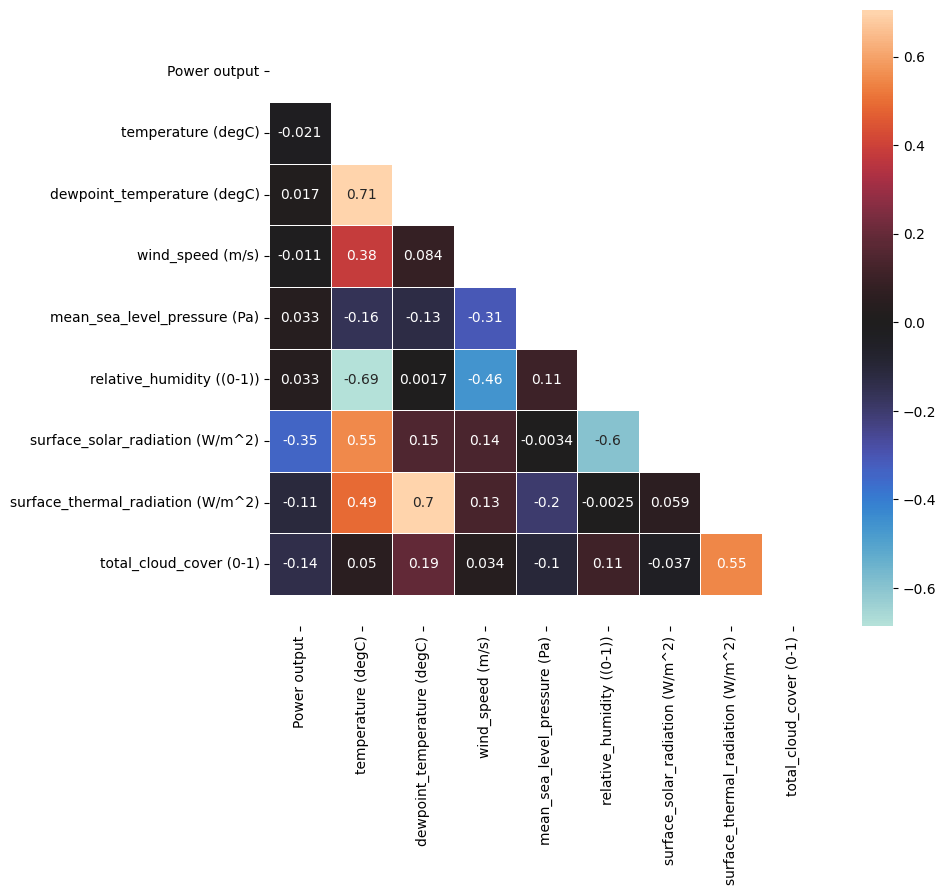

In [25]:
corrs = solar2.corr()
mask = np.triu(np.ones_like(corrs, dtype=np.bool)) # create a mask to only show entries below the main diagonal
f, ax = plt.subplots(figsize=(10, 8))
# plot the heatmap with a colour bar
sns.heatmap(corrs, mask=mask, center=0, annot=True, square=True, linewidths=.5)
# adjust the top and bottom, so that we can see the whole figure
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

<ipython-input-26-781189d350f8>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corrs, dtype=np.bool)) # create a mask to only show entries below the main diagonal


(9.5, -0.5)

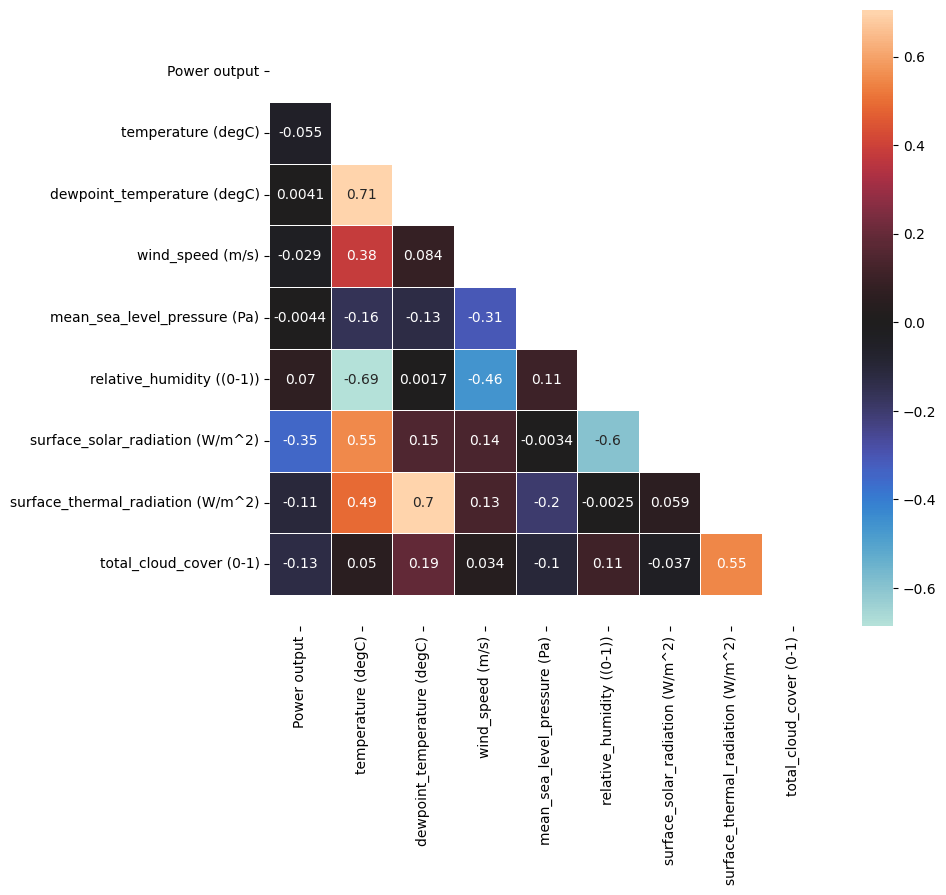

In [26]:
corrs = solar3.corr()
mask = np.triu(np.ones_like(corrs, dtype=np.bool)) # create a mask to only show entries below the main diagonal
f, ax = plt.subplots(figsize=(10, 8))
# plot the heatmap with a colour bar
sns.heatmap(corrs, mask=mask, center=0, annot=True, square=True, linewidths=.5)
# adjust the top and bottom, so that we can see the whole figure
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

<ipython-input-27-cc56bda8b8ff>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corrs, dtype=np.bool)) # create a mask to only show entries below the main diagonal


(9.5, -0.5)

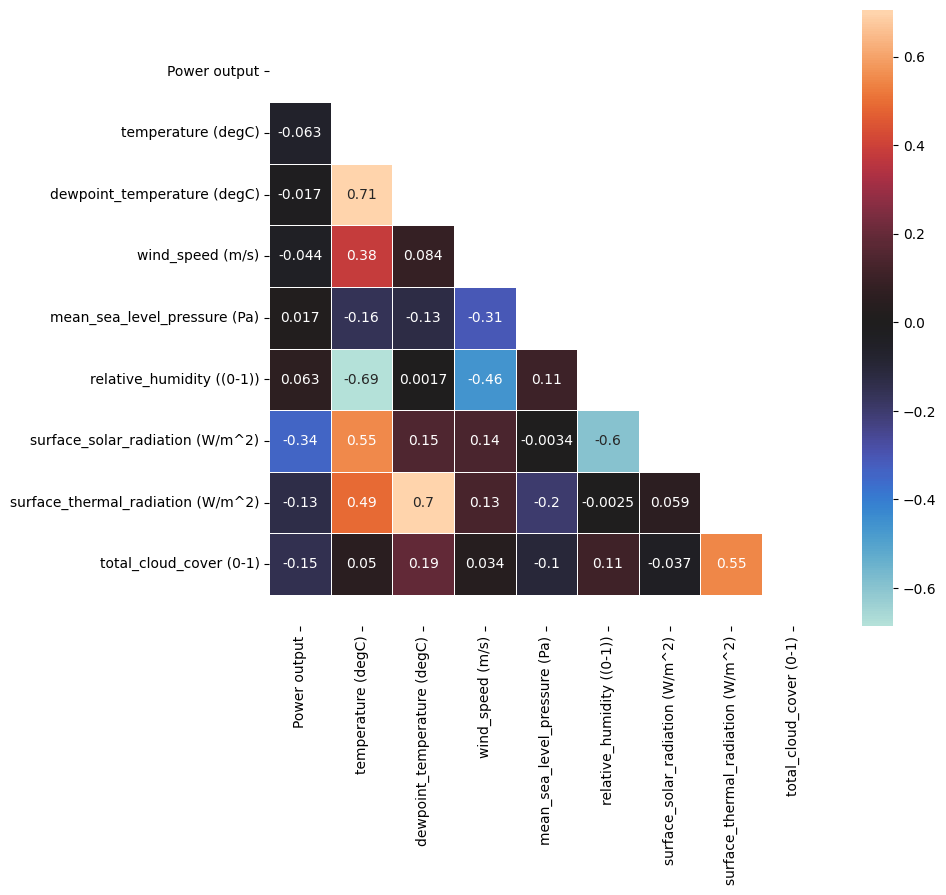

In [27]:
corrs = solar5.corr()
mask = np.triu(np.ones_like(corrs, dtype=np.bool)) # create a mask to only show entries below the main diagonal
f, ax = plt.subplots(figsize=(10, 8))
# plot the heatmap with a colour bar
sns.heatmap(corrs, mask=mask, center=0, annot=True, square=True, linewidths=.5)
# adjust the top and bottom, so that we can see the whole figure
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

<ipython-input-28-cc56bda8b8ff>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corrs, dtype=np.bool)) # create a mask to only show entries below the main diagonal


(9.5, -0.5)

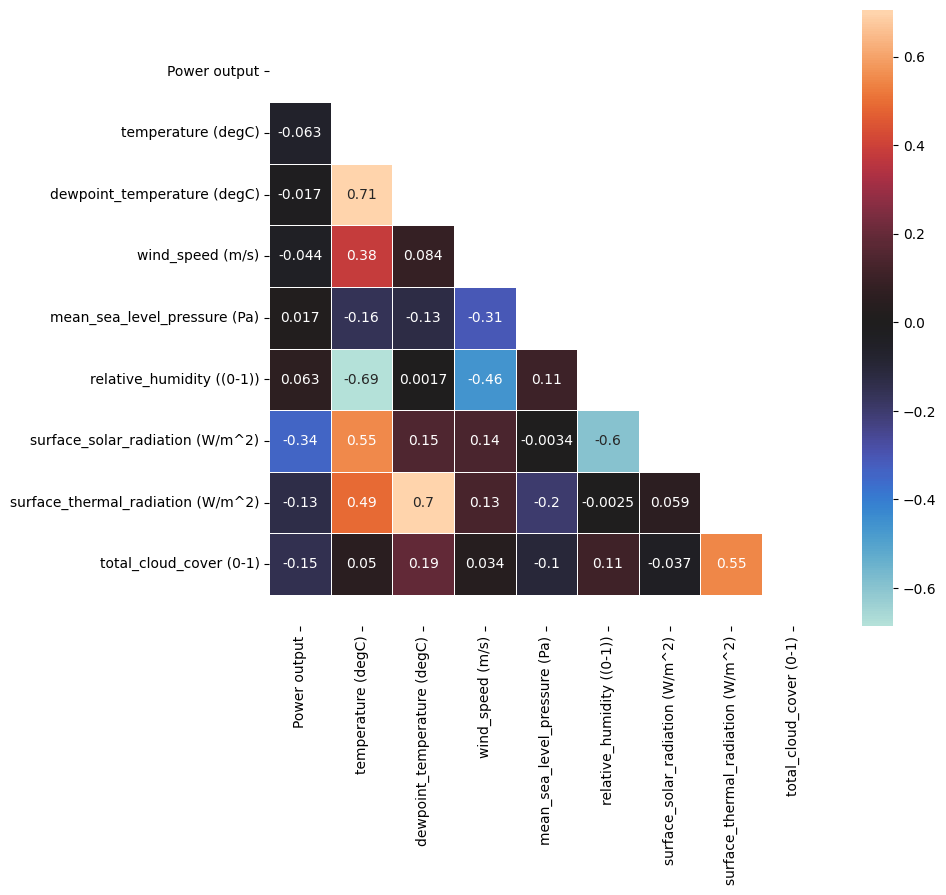

In [28]:
corrs = solar5.corr()
mask = np.triu(np.ones_like(corrs, dtype=np.bool)) # create a mask to only show entries below the main diagonal
f, ax = plt.subplots(figsize=(10, 8))
# plot the heatmap with a colour bar
sns.heatmap(corrs, mask=mask, center=0, annot=True, square=True, linewidths=.5)
# adjust the top and bottom, so that we can see the whole figure
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [54]:
def linearreg(train, test):
  linear = LinearRegression() #loading linear regression model
  X_train = train.drop(['Power output'],axis=1) #finding x_train
  Y_train = train['Power output']  #finding y_train
  X_train_columns = X_train.columns
  scaler = MinMaxScaler()
  nX_train =  pd.DataFrame(scaler.fit_transform(X_train), columns = X_train_columns)
  X_test = test.drop(['Power output'],axis=1)
  Y_test = test['Power output']
  X_test_columns = X_test.columns
  nX_test =  pd.DataFrame(scaler.fit_transform(X_test), columns = X_test_columns)
  inear = LinearRegression()

  linear.fit(nX_train,Y_train)

  training_predictions = linear.predict(nX_train)
  testing_predictions = linear.predict(nX_test)

  return pd.DataFrame({
      "R^2": {
          "train": r2_score(Y_train, training_predictions),
          "test": r2_score(Y_test, testing_predictions)
      },
      "RMSE": {
          "train": mean_squared_error(Y_train, training_predictions, squared=False),
          "test": mean_squared_error(Y_test, testing_predictions, squared=False),
      },
      "MAE": {
          "train": mean_absolute_error(Y_train, training_predictions),
          "test": mean_absolute_error(Y_test, testing_predictions),
      },
  })

In [53]:
linearreg(solar1_train, solar1_test)

,R^2,RMSE,MAE
train,0.204988,3.047326,2.528206
test,0.258221,3.678208,2.860220
